In [2]:
from __future__ import division
from __future__ import print_function
import datetime
import dateutil.parser
from glob import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import pandas as pd
import pandas.io.gbq
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import KFold
import keras
from keras.models import Sequential, Model as KerasModel
from keras.layers import Dense, Dropout, Flatten, MaxoutDense, LeakyReLU, ELU, Input
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers.core import Activation
from keras import backend as K
from keras.engine.topology import Layer
from keras import optimizers
assert K.image_data_format() == 'channels_last'
%matplotlib inline

hour = 60 * 60

Using TensorFlow backend.


In [3]:
# Step 1. Figure out where we are going to get the train and test data
# Break up by boat – if we validate using the same boat validated by
# two different people it will wildly optimistic

paths = (glob("labeled_data/without_logbook_data/*.json") +
         glob("labeled_data/with_logbook_data/*.json"))

all_paths = paths + glob("unlabelled_data/*.json") + glob("allboats/*.json")

def path_to_set(x):
    return '_'.join(os.path.splitext(os.path.basename(x))[0].split('_')[:4])
data_sets = sorted(set([path_to_set(x) for x in paths]))

# Set the seed so we get consistent results across runs 
# (Unless we add more data sets, then this is going to change!)
np.random.seed(888)    
np.random.shuffle(data_sets)

n_sets = len(data_sets)

def is_sorted(x):
    x = np.asarray(x)
    ge = (x[1:] >= x[:-1])
    return np.alltrue(ge)

def is_sorted_strict(x):
    x = np.asarray(x)
    ge = (x[1:] > x[:-1])
    return np.alltrue(ge)

# Don't include the observer data 
def is_valid_path(x):
    return 'Observer' not in os.path.basename(x)

def make_train_test_sets(n):
    test_sets = set(data_sets[n:n+1])
    train_sets = set(data_sets) - test_sets
    return train_sets, test_sets

def make_paths(sets):
    return [x for x in all_paths if path_to_set(x) in sets and is_valid_path(x)]

def make_train_test_paths(n=0):
    train_sets, test_sets = make_train_test_sets(n)
    return make_paths(train_sets), make_paths(test_sets)

train_paths, test_paths = make_train_test_paths(0)

# Note:
# 0 = unlabeled /nothing
# 1 = setting
# 2 = between setting and hauling
# 3 = hauling

In [17]:
# How many different labelled tracks do we have, how many unique tracks
track_ids = []
for p in paths:
    name = os.path.splitext(os.path.basename(p))[0]
    track_id = '_'.join(name.split('_')[:4])
    track_ids.append(track_id)
    
print(len(track_ids), "total tracks")
print(len(set(track_ids)), "unique tracks")  

# How many of these were labelled tracks
labelled_track_ids = []
for p in glob("labeled_data/with_logbook_data/*.json"):
    name = os.path.splitext(os.path.basename(p))[0]
    track_id = '_'.join(name.split('_')[:4])
    labelled_track_ids.append(track_id)
print(len(labelled_track_ids), "total logbook tracks")
print(len(set(labelled_track_ids)), "unique logbook tracks")  

37 total tracks
13 unique tracks
12 total logbook tracks
3 unique logbook tracks


In [6]:
# Step 2: Load the data

def load_data(path):
    with open(path) as f:
        obj = json.loads(f.read())
    obj['raw_timestamps'] = obj['timestamps']
    obj['timestamps'] = [dateutil.parser.parse(x) for x in obj['timestamps']]
    mask = np.ones_like(obj['timestamps'])
    for field in ['sogs', 'courses']:
        mask &= [(x is not None) for x in obj[field]]
    for field in ['timestamps', 'lats', 'lons', 'sogs', 'courses']:
        obj[field] = [x for (i, x) in enumerate(obj[field]) if mask[i]]
    return obj

def lin_interp(obj, key, delta, mask=None, func=None):
    assert delta % 1 == 0, 'delta must be a whole number of seconds'
    fp = obj[key]
    timestamps = obj['timestamps']
    assert is_sorted(timestamps)
    if mask is not None:
        fp = [x for (i, x) in enumerate(fp) if mask[i]]
        timestamps = [x for (i, x) in enumerate(timestamps) if mask[i]]
    if func is not None:
        fp = func(fp)
    ts0 = timestamps[0]
    xp = np.array([int((ts - ts0).total_seconds()) for ts in timestamps])
    a_smidgen = 0.1 # Added so that we capture the last point if it's on an even delta
    x = np.arange(xp[0], xp[-1] + a_smidgen, delta)
    return x, np.interp(x, xp, fp)

def compute_xp(obj, mask):
    timestamps = obj['timestamps']
    if mask is not None:
        timestamps = [x for (i, x) in enumerate(timestamps) if mask[i]]
    ts0 = timestamps[0]
    xp = np.array([int((ts - ts0).total_seconds()) for ts in timestamps])
    return xp

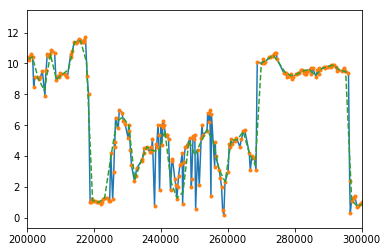

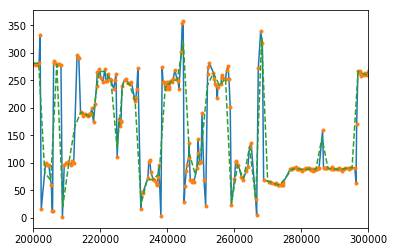

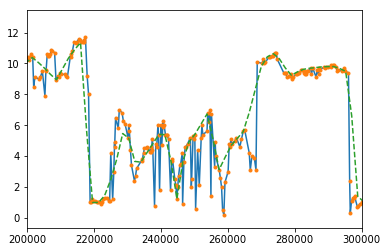

In [7]:
# Demo interpolation and masking

obj = load_data(train_paths[0])
x = [(x - obj['timestamps'][0]).total_seconds() for x in obj['timestamps']]

plt.plot(x, obj['sogs'])
plt.plot(x, obj['sogs'], '.')
xi, yi = lin_interp(obj, 'sogs', 30 * 60)
plt.plot(xi, yi, '--')
plt.xlim(200000, 300000)
plt.show()

plt.plot(x, obj['courses'])
plt.plot(x, obj['courses'], '.')
xi, yi = lin_interp(obj, 'courses', 30 * 60)
plt.plot(xi, yi, '--')
plt.xlim(200000, 300000)
plt.show()

plt.plot(x, obj['sogs'])
plt.plot(x, obj['sogs'], '.')
mask = np.arange(len(x)) % 8 == 0
xi, yi = lin_interp(obj, 'sogs', 30 * 60, mask=mask)
plt.plot(xi, yi, '--')
plt.xlim(200000, 300000)
plt.show()


In [ ]:
def delta_times(ti, t):
    """Compute maximimum gap between ti (interpolated) and t (original)"""
    assert ti[0] >= t[0]
    assert ti[-1] <= t[-1]
    prv = np.searchsorted(t, ti, side='left')
    nxt = np.searchsorted(t, ti, side='right')
    dtp = abs(ti - t[prv])
    dtn = abs(ti - t[nxt])
    return np.minimum(dtn, dtp)

def cos_deg(x):
    return np.cos(np.radians(x))

def sin_deg(x):
    return np.sin(np.radians(x))


def build_features(obj, delta, skip_label=False, keep_frac=1.0):
    n_pts = len(obj['lats'])
    assert 0 < keep_frac <= 1
    if keep_frac == 1:
        mask = None
    else:           
        # Build a random mask with probaility keep_frac. Force
        # first and last point to be true so the time frame
        # stays the same.
        mask = np.random.uniform(0, 1, size=[n_pts]) < keep_frac
        mask[0] = mask[-1] = True 
        
    # Replace missing speeds with arbitrary 3.5 (between setting and hauling)
    # TODO: use implied speed instead
    assert np.isnan(obj['sogs']).sum() == np.isnan(obj['courses']).sum() == 0 
    
    v = np.array(obj['sogs'])
    v[np.isnan(v)] = 3.5
    obj['sogs'] = v
    xi, speeds = lin_interp(obj, 'sogs', delta, mask=mask)
    y0 = speeds
    #
    _, cos_yi = lin_interp(obj, 'courses', delta, mask=mask, func=cos_deg)
    _, sin_yi = lin_interp(obj, 'courses', delta, mask=mask, func=sin_deg)
    angle_i = np.arctan2(sin_yi, cos_yi)
    y1 = angle_i
    #
    _, y2 = lin_interp(obj, 'lats', delta, mask=mask)
    # Longitude can cross the dateline, so interpolate useing cos / sin
    _, cos_yi = lin_interp(obj, 'lons', delta, mask=mask, func=cos_deg)
    _, sin_yi = lin_interp(obj, 'lons', delta, mask=mask, func=sin_deg)
    y3 = np.degrees(np.arctan2(sin_yi, cos_yi))
    # delta times
    xp = compute_xp(obj, mask)
    dts = delta_times(xi, xp)
    y4 = dts
    # Times
    t0 = obj['timestamps'][0]
    t = [(t0 + datetime.timedelta(seconds=delta * i)) for i in range(len(y1))]
    y = np.transpose([y0, y1, y2, y3, y4])
    #
    # Quick and dirty nearest neighbor (only works for binary labels I think)
    if skip_label:
        label_i = None
    else:
        _, raw_label_i = lin_interp(obj, 'fishing', delta, mask=None, # Don't mask labels - use undropped labels for training 
                                    func=lambda x: np.array(x) == 1) # is it a set
        label_i = raw_label_i > 0.5
    #
    return t, xi, y, label_i


In [9]:
def cook_features(raw_features, angle=None, noise=None, far_time=3 * hour):
    speed = raw_features[:, 0]
    angle = np.random.uniform(0, 2*np.pi) if (angle is None) else angle
    angle_feat = raw_features[:, 1] + angle
    dir_a = np.cos(angle) * raw_features[:, 2] - np.sin(angle) * raw_features[:, 3]
    dir_a -= dir_a.mean()
    dir_b = np.sin(angle) * raw_features[:, 2] + np.cos(angle) * raw_features[:, 3]
    dir_b -= dir_b.mean()
    if noise is None:
        noise = np.random.normal(0, .05, size=len(raw_features[:, 4]))
    noisy_time = np.maximum(raw_features[:, 4] / float(far_time) + noise, 0)
    is_far = np.exp(-noisy_time) 
    return np.transpose([speed, 
                      np.cos(angle_feat), 
                      np.sin(angle_feat),
                      dir_a,
                      dir_b,
                      is_far
                      ])

def generate_data(sets, window, delta, min_samples, label_window=None, seed=888, skip_label=False,
                 keep_fracs=(1,), noise=None):
    paths = make_paths(sets)
    if label_window is None:
        label_window = delta
    assert window % delta == 0, 'delta must evenly divide window'
    assert label_window % delta == 0, 'delta must evenly divide label_window'
    assert window >= label_window, "window must be at least as large as label_window"
    # Weight so that sets with multiple classification get sqrt(n) more representation
    # Since they have some extra information (n is the number of classifications)
    subsamples = int(round(min_samples / np.sqrt(len(paths))))
    # Set seed for reproducibility
    np.random.seed(seed)
    times = []
    features = []
    setting = []
    labels = []
    window_pts = window // delta
    lbl_pts = label_window // delta
    lbl_offset = (window_pts - lbl_pts) // 2
    for p in paths:
        for kf in keep_fracs:
            obj = load_data(p)
            t, x, y, label = build_features(obj, delta=delta, skip_label=skip_label, keep_frac=kf)
            min_ndx = 0
            max_ndx = len(x) - window_pts
            if max_ndx < min_ndx:
                print("skipping", p, "because it is too short")
                continue
            for _ in range(subsamples):
                ndx = np.random.randint(min_ndx, max_ndx + 1)
                times.append(t[ndx:ndx+window_pts])
                raw_features = y[ndx:ndx+window_pts]
                features.append(cook_features(raw_features, noise=noise))

                if skip_label:
                    setting.append(None)
                    labels.append(None)
                else:
                    setting.append(label[ndx:ndx+window_pts])
                    windowed_labels = label[ndx+lbl_offset:ndx+lbl_offset+lbl_pts]
                    lbl = windowed_labels.sum() > 0
                    labels.append(lbl)
    return times, np.array(features), np.array(labels), np.array(setting)

In [10]:
class BaseModel(object):
    
    def flatten(self, x):
        x = np.asarray(x)
        return x.reshape(x.shape[0], -1)

class SimpleTreeEnsembleModel(BaseModel):
    
    def __init__(self):
        self.clf1 = GradientBoostingClassifier(n_estimators=50, max_depth=5, 
                                               subsample=0.8, max_features=0.9)
        self.clf2 = RandomForestClassifier(n_estimators=100, n_jobs=-1)
        self.clf3 = GradientBoostingClassifier(n_estimators=50, max_depth=5, subsample=0.8, 
                                               max_features=0.9, loss='exponential')
        self.preprocessor = PCA(n_components=50)
        
    def preprocess(self, x):
        return self.preprocessor.transform(self.flatten(x))
        
    def fit(self, x, labels):
        self.preprocessor.fit(self.flatten(x))
        x1 = self.preprocess(x)
        self.clf1.fit(x1, labels)
        self.clf2.fit(x1, labels)
        self.clf3.fit(x1, labels)
        return self

    def predict(self, x):
        x1 = self.preprocess(x)
        proba = (self.clf1.predict_proba(x1)[:, 1] + 
                 self.clf2.predict_proba(x1)[:, 1] + 
                 self.clf3.predict_proba(x1)[:, 1]) / 3.0
        return proba > 0.5

In [11]:

class FCNetModel(BaseModel):

    def __init__(self, window, width):
        model = Sequential()
        model.add(Dense(width, input_shape=(window * 6,)))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(width))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(width))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1))
        model.add(Activation('sigmoid'))
        model.compile(optimizer=optimizers.Adam(decay=0.1), 
                      loss='binary_crossentropy', metrics=["accuracy"])
        self.model = model
        
    def preprocess(self, x):
        return self.flatten(x)
        
    def fit(self, x, labels):
        x1 = self.preprocess(x)
        l1 = np.asarray(labels).reshape((len(labels), 1))
        self.model.fit(x1, l1, epochs=20)
        return self

    def predict(self, x):
        x1 = self.preprocess(x)
        return self.model.predict(x1)[:, 0] > 0.5
    

In [12]:
class ConvNetModel(BaseModel):
    
    # NEEDS a bunch of CV tuning!

    def __init__(self, window, depth, width):
        model = Sequential()
        model.add(Conv1D(depth, 3, input_shape=(window, 6)))
        model.add(LeakyReLU())
        model.add(Conv1D(depth, 3))
        model.add(LeakyReLU())
        model.add(Conv1D(2 * depth, 3))
        model.add(LeakyReLU())
        model.add(MaxPooling1D(3, strides=2))
        model.add(Dropout(0.1))
        model.add(Conv1D(2 * depth, 3))
        model.add(LeakyReLU())
        model.add(Dropout(0.1))
        model.add(Conv1D(2 * depth, 3))
        model.add(LeakyReLU())
        model.add(Dropout(0.1))
        model.add(Conv1D(4 * depth, 3))
        model.add(LeakyReLU())
        model.add(MaxPooling1D(3, strides=2))
        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(Dense(width))
        model.add(LeakyReLU())
        model.add(Dropout(0.5))
        model.add(Dense(width))
        model.add(LeakyReLU())
        model.add(Dropout(0.5))
        model.add(Dense(1))
        model.add(Activation('sigmoid'))
        opt = optimizers.Adam(lr=0.001, decay=0.1)
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["accuracy"])
        self.model = model     
    
    def preprocess(self, x):
        return np.asarray(x)
        
    def fit(self, x, labels, epochs=1):
        x1 = self.preprocess(x)
        l1 = np.asarray(labels).reshape((len(labels), 1))
        self.model.fit(x1, l1, epochs=epochs)
        return self

    def predict(self, x):
        x1 = self.preprocess(x)
        return self.model.predict(x1)[:, 0] > 0.5

In [13]:
template = '''
{static_table}

  SELECT
    timestamp,
    IF(local_time > sunset
      OR local_time < sunrise,
      TRUE,
      FALSE) night
  FROM (
    SELECT
      timestamp,
      sunrise,
      24-sunrise sunset,
      IF(local_hours < 0,
        local_hours+24,
        IF(local_hours>24,
          local_hours-24,
          local_hours)) local_time
    FROM (
      SELECT
        timestamp,
        EXTRACT(dayofyear
        FROM
          timestamp) day_of_year,
        EXTRACT(hour
        FROM
          timestamp) + EXTRACT(minute
        FROM
          timestamp)/60 + lon/360*24 local_hours,
        FLOOR(lat) lat_bin
      FROM
        static_table ) a
    LEFT JOIN (
      SELECT
        lat,
        day,
        AVG(sunrise) AS sunrise
      FROM
        `gfw_research_precursors.sunrise`
      GROUP BY lat, day
        ) b
    ON
      a.day_of_year = b.day
      AND a.lat_bin = b.lat ) 
ORDER BY timestamp
'''

def _is_night(timestamps, lats, lons):
    # make a table of timestamps and lats
    lines = ["SELECT TIMESTAMP('{}') AS timestamp, {} AS lat, {} AS lon".format(
                timestamps[0].isoformat(), lats[0], lons[0])]
    for ts, lat, lon in zip(timestamps[1:], lats[1:], lons[1:]):
        lines.append("SELECT TIMESTAMP('{}'), {}, {}".format(ts.isoformat(), lat, lon))
    static_table = "WITH static_table AS ({})".format("\nUNION ALL\n".join(lines))
    q = template.format(static_table=static_table)
    return pd.read_gbq(q, project_id='world-fishing-827', verbose=True, dialect='standard').night

def is_night(timestamps, lats, lons, n=800):
    results = []
    for i in range(0, len(timestamps), n):
        results.extend(_is_night(timestamps[i:i+n], lats[i:i+n], lons[i:i+n]))
    return results

In [14]:
def dump_hourly(mdl, set_name, t, y, p, window_pts, label_pts, classifications=(), suffix='', prefix=''):
    path = "output/{}{}_hourly_{}{}.json".format(prefix, set_name, mdl.__class__.__name__, suffix)
    offset = (window_pts - label_pts) // 2
    min_ndx = 0
    max_ndx = len(y) - window_pts
    ti = t[min_ndx+offset:max_ndx+offset]
    lats = y[min_ndx+offset:max_ndx+offset, 2]
    lons = y[min_ndx+offset:max_ndx+offset, 3]
    json_classifications = []
    for v in classifications:
        json_classifications.append([int(w) for w in v[min_ndx+offset:max_ndx+offset]])
    obj = {
        'timestamp' : [v.isoformat() for v in ti],
        'latitude' : [float(v) for v in lats],
        'longitude' : [float(v) for v in lons],
        'is_setting' : [int(v) for v in p],
        'is_night' : [int(v) for v in is_night(ti, lats, lons)],
        'classifications' : json_classifications,
        'time_to_nearest_ping' : [float(v) for v in y[:, 4]]
    }
    with open(path, 'w') as f:
        f.write(json.dumps(obj))
        

def dump_as_tool_json(mdl, set_name, t, y, p, window_pts, label_pts, suffix='', prefix=''):
        path = "output/{}{}_model_{}.json".format(prefix, set_name, mdl.__class__.__name__)
        min_ndx = 0
        max_ndx = len(y) - window_pts
        offset = (window_pts - label_pts) // 2
        paths =  make_paths([set_name])
        if not paths:
            print("no paths for", set_name)
            return
        a_set_path = paths[0]
        with open(a_set_path) as f:
            obj = json.loads(f.read())
        ds = [(dateutil.parser.parse(dt) - t[0]).total_seconds() for dt in obj['timestamps']]
        xi = [(dt - t[0]).total_seconds() for dt in t]
        label_i = (np.interp(ds, xi[min_ndx+offset:max_ndx+offset], p, left=0, right=0) > 0.5).astype(int)
        obj['fishing'] = list(label_i)
        assert len(obj['fishing']) == len(obj['timestamps']) == len(obj['lats'])
        with open("output/{}{}_tool_{}{}.json".format(prefix, set_name, mdl.__class__.__name__, suffix), 'w') as f:
            f.write(json.dumps(obj))

In [15]:
def hybrid_pool_layer(x, pool_size=2):
    return Conv1D(int(x.shape[-1]), 1)(
        keras.layers.concatenate([
            MaxPooling1D(pool_size, strides=2)(x),
            AveragePooling1D(pool_size, strides=2)(x)]))


class ConvNetModel2(BaseModel):
    
    def __init__(self, window, depth, width):
        input_layer = Input(shape=(window, 6))
        y = input_layer
        y = Conv1D(depth, 3)(y)
        y = ELU()(y)
        y = keras.layers.BatchNormalization(scale=False, center=False)(y)
        y = Conv1D(depth, 3)(y)
        y = ELU()(y)
        y = keras.layers.BatchNormalization(scale=False, center=False)(y)
        y = hybrid_pool_layer(y)
        
        y = Conv1D(2 * depth, 3)(y)
        y = ELU()(y)
        y = keras.layers.BatchNormalization(scale=False, center=False)(y)
        y = Conv1D(2 * depth, 3)(y)
        y = ELU()(y)
        y = keras.layers.BatchNormalization(scale=False, center=False)(y)
        y = hybrid_pool_layer(y)
        
        y = Flatten()(y)
        y = Dense(width)(y)
        y = ELU()(y)
        y = keras.layers.BatchNormalization(scale=False, center=False)(y)

        y = Dense(width)(y)
        y = ELU()(y)
        y = Dropout(0.5)(y)

        y = Dense(1)(y)
        y = Activation('sigmoid')(y)
        output_layer = y
        model = KerasModel(inputs=input_layer, outputs=output_layer)
        opt = optimizers.Adam(lr=0.01, decay=0.1)
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["accuracy"])
        self.model = model  
        self.model = model     
    
    def preprocess(self, x):
        return np.asarray(x)
        
    def fit(self, x, labels, epochs=1, batch_size=32):
        x1 = self.preprocess(x)
        l1 = np.asarray(labels).reshape((len(labels), 1))
        self.model.fit(x1, l1, epochs=epochs, batch_size=batch_size)
        return self

    def predict(self, x):
        x1 = self.preprocess(x)
        return self.model.predict(x1)[:, 0] > 0.5

In [19]:
delta = hour
window = (29 + 4*6) *  hour
window_pts = window // delta
label_pts = 1
offset = (window_pts - label_pts) // 2
keep_fracs = [1, 0.75, 0.5, 0.25]
max_epochs = 20
decay = 0.1

Model = lambda : ConvNetModel2(window // delta, 32, 512) 

In [ ]:
f1_scores = []
class_b_f1_scores = []
david_class_b_f1_scores = []

def test_model(mdl, test_sets, window, delta, min_samples, keep_frac=1.0):
    times, features, labels, _ = generate_data(test_sets, window=window, delta=delta, 
                                               min_samples=100, keep_fracs=(keep_frac,), noise=0)
    predictions = mdl.predict(features)
    print("model accuracy:", accuracy_score(labels, predictions))
    precision, recall, fscore, support = precision_recall_fscore_support(labels, predictions)
    print("model precision:", precision[1])
    print("model recall:", recall[1])
    print("model f1-score:", fscore[1])
    print("model set support:", support[1])
    print()
    return fscore
    
def infer_sets_everywhere(obj, mdl, window, delta):
    t, x, y, label = build_features(obj, delta=delta)
    window_pts = window // delta
    label_pts = 1
    features = []
    offset = (window_pts - label_pts) // 2
    min_ndx = 0
    max_ndx = len(x) - window_pts
    for i in range(min_ndx, max_ndx):
        raw_features = y[i:i+window_pts]
        features.append(cook_features(raw_features, angle=0, noise=0))
    features = np.asarray(features)
    predictions = mdl.predict(features)
    return min_ndx, max_ndx, offset, x, predictions
    
    
folder = KFold(n_splits=5, random_state=888, shuffle=True)
all_agreements = {}
for i, (train_index, test_index) in enumerate(folder.split(data_sets)):
    print("Fold", i)
    data_sets_array = np.asarray(data_sets)
    train_sets = data_sets_array[train_index]
    test_sets = data_sets_array[test_index]
    
    # Train the model
    times, features, labels, _ = generate_data(train_sets, min_samples=1000, window=window, delta=delta,
                                                  keep_fracs=keep_fracs)
    mdl = Model().fit(features, labels, epochs=max_epochs, batch_size=32) 
    
    for set_name in test_sets:
        # Stash info about agreement with annotators for later display
        classifications = {}
        paths = make_paths([set_name])
        for path in paths:
            annotator = os.path.basename(path).split('_')[4]
            obj = load_data(path)
            t, x, y, label = build_features(obj, delta=delta)
            classifications[annotator] = np.asarray(label)
        min_ndx, max_ndx, offset, x, predictions = infer_sets_everywhere(obj, mdl, window, delta)
        for x in classifications:
            classifications[x] = classifications[x][min_ndx + offset:max_ndx + offset]
        classifications['_consensus_'] = np.round(np.mean(classifications.values(), axis=0))
        classifications['_model_'] = np.asarray(predictions)
        mask = y[min_ndx + offset:max_ndx + offset, 4] < 4 * hour
        all_agreements[set_name] = classifications
    
    # Test the model
    fscore = test_model(mdl, test_sets, window, delta, min_samples=1000)
    f1_scores.append(fscore[1])

    # Visualize and dump model output
    for set_name in test_sets:
        classifications = []
        for path in make_paths([set_name]):
            obj = load_data(path)
            t, x, y, label = build_features(obj, delta=delta)
            classifications.append(label)
        min_ndx, max_ndx, offset, x, predictions = infer_sets_everywhere(obj, mdl, window, delta)
        dump_hourly(mdl, set_name, t, y, predictions, window_pts, label_pts, classifications=classifications, 
                                  prefix='tests/')
        dump_as_tool_json(mdl, set_name, t, y, predictions, window_pts, label_pts, 
                                  prefix='tests/')
        
        
print("Score derived from random sampling:")
print("  Average F1-Score:", np.mean(f1_scores))

# Expected F1 ~0.859784449771

Metrics (computed against consensus for each set_name, then averaged across set_names
  Accuracy: 0.94
  Recall: 0.91
  Precision: 0.90
  F1-score: 0.90


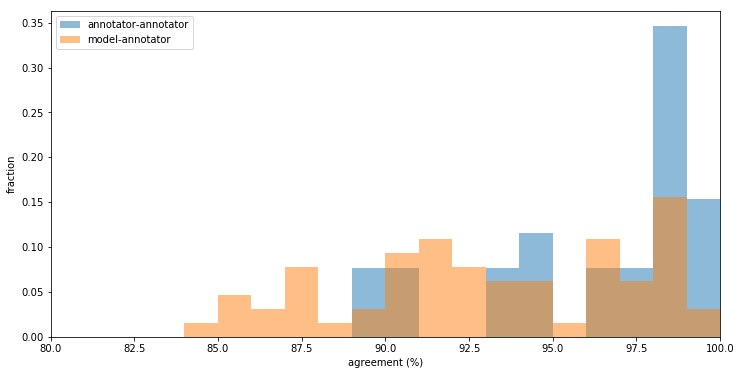

In [155]:
# Compute metrics based on K-fold cross validation 
# Also display comparison with and between human annotators.
agreement_pairs = []
accuracies = []
recalls = []
precisions = []
f1_scores = []
for set_name, classifications in all_agreements.items():
        all_annotators = sorted(classifications)
        precision, recall, fscore, support = precision_recall_fscore_support(classifications['_consensus_'], 
                                                                             classifications['_model_'])
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(fscore)
        accuracies.append((classifications['_consensus_'] == classifications['_model_']).mean())

        # TODO: mask out points more that 4? hours away from a ping
        for i, a1 in enumerate(all_annotators):
            for a2 in all_annotators[i+1:]:
                agreement = (#mask * 
                             (classifications[a1] == classifications[a2])).mean() / mask.mean()
                all_agreements_2.append((a1, a2, agreement))
    
# Note that averaging across set names is equivalent to averaging across folds, since each set_name
# occurs exactly once in either case.
print("Metrics (computed against consensus for each set_name, then averaged across set_names")
print("  Accuracy: {:.2f}".format(np.mean(accuracies)))
print("  Recall: {:.2f}".format(np.mean(recalls)))
print("  Precision: {:.2f}".format(np.mean(precisions)))
print("  F1-score: {:.2f}".format(np.mean(f1_scores)))


    
model_agreements = np.array([x for (a, b, x) in all_agreements_2 if b == '_model_' and a != '_consensus_'])
annotator_agreements = np.array([x for (a, b, x) in all_agreements_2 if b not in ('_model_', '_consensus_')])
consensus_agreements = np.array([x for (a, b, x) in all_agreements_2 if (a, b) == ('_consensus_', '_model_')])
assert not  [x for (a, b, x) in all_agreements_2 if (a, b) == ('_model_', '_model_')]


plt.figure(figsize=(12,6))
plt.hist(100 * annotator_agreements, bins=np.linspace(0, 100, 101), alpha=0.5, 
         label="annotator-annotator", normed=True)
plt.hist(100 * model_agreements, bins=np.linspace(0, 100, 101), alpha=0.5, 
         label="model-annotator", normed=True)
plt.xlim(80, 100)
plt.xlabel("agreement (%)")
plt.ylabel("fraction")
plt.legend()
plt.show()

# Some of the performance discrepencancy between the nnet and human raters may be related to
# port visits, which the net tends to get wrong, while human raters get them consistently 
# correct. Humans can see the locations of ports during their rating, while the net has no
# information about the distance to port. However, this has not been investigated yet.

In [ ]:
# Train the model on all of the data
times, features, labels, _ = generate_data(data_sets, min_samples=1000, window=window, 
                                           delta=delta, keep_fracs=keep_fracs)
mdl = Model().fit(features, labels, epochs=max_epochs)

In [ ]:
# Then run against `allboats`

all_sets = set([path_to_set(x) for x in glob("allboats/*.json")])
processed = set([path_to_set(x).rsplit('_', 2)[0] for x in glob("output/all/*.json")])

for set_name in sorted(all_sets - processed):   
    print(set_name, ": ", end='')
    t0 = time.time()
    _all_paths = all_paths
    try:
        all_paths = glob("allboats/*.json")
        paths = make_paths(set_name)
    finally:
        all_paths = _all_paths
    [path] = paths
    obj = load_data(path)
    t, x, y, label = build_features(obj, delta=delta, skip_label=True)
    min_ndx = 0
    max_ndx = len(t) - window_pts
    features = []
    for i in range(min_ndx, max_ndx):
        raw_features = y[i:i+window_pts]
        features.append(cook_features(raw_features, angle=77))
    predictions = mdl.predict(features)
    dump_hourly(mdl, set_name, t, y, predictions, window_pts, label_pts, prefix='all/')
    dump_as_tool_json(mdl, set_name, t, y, predictions, window_pts, label_pts, prefix='all/')
    print(time.time() - t0, 's')    